# 5. Modeling
[[back to top](#sections)]

In [2]:
# Import libraries
import pickle
import pandas as pd
import sys; sys.path.insert(0, '..')
import importlib
import collections, numpy
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight

In [8]:
# import modules
import src.models
importlib.reload (src.models)
from src.models import func_remove_var
from src.models import func_keep_var
from src.models import func_transform_var
from src.models import func_Shuffle_cat
from src.models import func_Shuffle_num
from src.models import func_classfication_pipeline 
from src.models import func_regression_pipeline
from src.models import func_transformed_var
from src.models import plot_pr_curve
from src.models import func_Shuffle_simple_cat

In [361]:
# Load data
with open('../data/interim/roadway/preprocessing/df.pkl', 'rb') as f:
    df = pickle.load(f)

In [362]:
df.isnull().sum().sort_values(ascending=False)

PC                   70
Pop_den              70
HCV                  70
AADT                 70
Crashes               0
                     ..
I_SHD1_WTH            0
I_SHD1_TYP            0
ACC_CNTL              0
overall_landuse       0
sub_segment_index     0
Length: 62, dtype: int64

In [364]:
df.head(2)

sub_segment_index  st_length  curve_ratio  one_way  bicycle_facility_width  \
0                  0  185.01332          1.0        0                     0.0   
1                  1  185.01332          1.0        0                     0.0   

  bicycle_path_category  bicycle_buffer_width bicycle_buffer_type  \
0                  None                   0.0                None   
1                  None                   0.0                None   

  bicycle_path_type bicycle_approach_alignment  ...  MUNI_NAME  NHS TRK_RT  \
0              None                       None  ...       0000    0      0   
1              None                       None  ...       0000    0      0   

    AADT   HCV Pop_den       PC  \
0  577.0  57.0   249.0  Unknown   
1  577.0  57.0   249.0  Unknown   

                                            geometry  Year Crashes  
0  LINESTRING (990250.010 1250037.162, 990247.945...  2014     0.0  
1  LINESTRING (990250.010 1250037.162, 990247.945...  2014     0.0  

[2 rows x 62 columns]

In [365]:
df.columns

Index(['sub_segment_index', 'st_length', 'curve_ratio', 'one_way',
       'bicycle_facility_width', 'bicycle_path_category',
       'bicycle_buffer_width', 'bicycle_buffer_type', 'bicycle_path_type',
       'bicycle_approach_alignment', 'bus_trips_total', 'crossing_aadt',
       'crossing_functional_classification', 'crossing_speed',
       'functional_classification', 'intersection_control_type',
       'lane_configuration', 'max_lanes_crossed', 'parking_lane_width',
       'marked_center_line', 'posted_speed', 'railroad_crossing_type',
       'right_turn_length', 'road_sign_type', 'sidewalk_buffer_width',
       'sidewalk_condition_score', 'sidewalk_width', 'sidewalk_buffer_type',
       'total_lanes', 'in_urbanized_area', 'volume_capacity',
       'overall_landuse', 'ACC_CNTL', 'I_SHD1_TYP', 'I_SHD1_WTH', 'I_SHD2_TYP',
       'I_SHD2_WTH', 'LN_WTH', 'LNS', 'MED_TYP', 'MED_WTH', 'SURF_TYP',
       'SURF_WTH', 'O_SHD1_TYP', 'O_SHD1_WTH', 'O_SHD2_TYP', 'O_SHD2_WTH',
       'OP_1_2_WAY'

In [366]:
df_urban=df[df['in_urbanized_area']=='Yes']
df_rural=df[df['in_urbanized_area']=='No']

In [367]:
with open('../data/processed/df_urban.pkl', 'wb') as f:
    pickle.dump(df_urban, f)
with open('../data/processed/df_rural.pkl', 'wb') as f:
    pickle.dump(df_rural, f)
with open('../data/processed/df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [2]:
import pickle
import pandas as pd
with open('../data/processed/df_urban.pkl', 'rb') as f:
    df_urban = pickle.load(f)
with open('../data/processed/df_rural.pkl', 'rb') as f:
    df_rural = pickle.load(f)
with open('../data/processed/df.pkl', 'rb') as f:
    df = pickle.load(f)

<a id='train-test-split'></a>

## 5.1. Train-Test Split
* The training data is static and temporal features of roadway sub-segments for 2014-2017.
* The training label is the number of crashes (for regression models) or crash categories (for classification models) for each sub-segments each year during 2014-2017.
* The testing data is static and temporal features of roadway sub-segments for 2018.
* The testing label is the number of crashes (for regression models) or crash categories (for classification models) for each sub-segments in 2018.

### 1) Champaign County

In [3]:
df_train = df[df['Year']<2018].iloc[:,0:61].copy()
df_train_label = df[df['Year']<2018].iloc[:,-1].copy()
df_test = df[df['Year']==2018].iloc[:,0:61].copy()
df_test_label = df[df['Year']==2018].iloc[:,-1].copy()

In [4]:
df_train.shape

(978980, 61)

In [5]:
df_train.head(2)

sub_segment_index  st_length  curve_ratio  one_way  bicycle_facility_width  \
0                  0  185.01332          1.0        0                     0.0   
1                  1  185.01332          1.0        0                     0.0   

  bicycle_path_category  bicycle_buffer_width bicycle_buffer_type  \
0                  None                   0.0                None   
1                  None                   0.0                None   

  bicycle_path_type bicycle_approach_alignment  ...   MPO  MUNI_NAME NHS  \
0              None                       None  ...  0990       0000   0   
1              None                       None  ...  0990       0000   0   

   TRK_RT   AADT   HCV Pop_den       PC  \
0       0  577.0  57.0   249.0  Unknown   
1       0  577.0  57.0   249.0  Unknown   

                                            geometry  Year  
0  LINESTRING (990250.010 1250037.162, 990247.945...  2014  
1  LINESTRING (990250.010 1250037.162, 990247.945...  2014  

[2 rows x 61 columns]

In [6]:
df_train_label.head(2)

0    0.0
1    0.0
Name: Crashes, dtype: float64

In [7]:
df_test.shape

(244745, 61)

In [8]:
df_test.head(2)

sub_segment_index  st_length  curve_ratio  one_way  \
979036                  0  185.01332          1.0        0   
979037                  1  185.01332          1.0        0   

        bicycle_facility_width bicycle_path_category  bicycle_buffer_width  \
979036                     0.0                  None                   0.0   
979037                     0.0                  None                   0.0   

       bicycle_buffer_type bicycle_path_type bicycle_approach_alignment  ...  \
979036                None              None                       None  ...   
979037                None              None                       None  ...   

         MPO  MUNI_NAME NHS  TRK_RT   AADT   HCV Pop_den       PC  \
979036  0990       0000   0       0  536.0  53.0   292.0  Unknown   
979037  0990       0000   0       0  536.0  53.0   292.0  Unknown   

                                                 geometry  Year  
979036  LINESTRING (990250.010 1250037.162, 990247.945...  2018  
979037  LINESTRING (990250.010 1250037.162, 990247.945...  2018  

[2 rows x 61 columns]

In [9]:
df_test_label.head(2)

979036    0.0
979037    0.0
Name: Crashes, dtype: float64

### 2) Urban/Rural

In [10]:
df_urban_train = df_urban[df_urban['Year']<2018].iloc[:,0:61].copy()
df_urban_train_label = df_urban[df_urban['Year']<2018].iloc[:,-1].copy()
df_urban_test = df_urban[df_urban['Year']==2018].iloc[:,0:61].copy()
df_urban_test_label = df_urban[df_urban['Year']==2018].iloc[:,-1].copy()

In [11]:
df_rural_train = df_rural[df_rural['Year']<2018].iloc[:,0:61].copy()
df_rural_train_label = df_rural[df_rural['Year']<2018].iloc[:,-1].copy()
df_rural_test = df_rural[df_rural['Year']==2018].iloc[:,0:61].copy()
df_rural_test_label = df_rural[df_rural['Year']==2018].iloc[:,-1].copy()

In [12]:
import pickle
with open('../data/processed/df_train.pkl', 'wb') as f:
    pickle.dump(df_train, f)
with open('../data/processed/df_train_label.pkl', 'wb') as f:
    pickle.dump(df_train_label, f)
with open('../data/processed/df_test.pkl', 'wb') as f:
    pickle.dump(df_test, f)
with open('../data/processed/df_test_label.pkl', 'wb') as f:
    pickle.dump(df_test_label, f)
with open('../data/processed/df_urban_train.pkl', 'wb') as f:
    pickle.dump(df_urban_train, f)
with open('../data/processed/df_urban_train_label.pkl', 'wb') as f:
    pickle.dump(df_urban_train_label, f)
with open('../data/processed/df_urban_test.pkl', 'wb') as f:
    pickle.dump(df_urban_test, f)
with open('../data/processed/df_urban_test_label.pkl', 'wb') as f:
    pickle.dump(df_urban_test_label, f)
with open('../data/processed/df_rural_train.pkl', 'wb') as f:
    pickle.dump(df_rural_train, f)
with open('../data/processed/df_rural_train_label.pkl', 'wb') as f:
    pickle.dump(df_rural_train_label, f)
with open('../data/processed/df_rural_test.pkl', 'wb') as f:
    pickle.dump(df_rural_test, f)
with open('../data/processed/df_rural_test_label.pkl', 'wb') as f:
    pickle.dump(df_rural_test_label, f)  

<a id='transformation-pipelines'></a>

## 5.2. Transformation & Modeling Pipelines

### 1) Explanatory variable subsets

#### * Remove list of variables 

In [4]:
import pickle
import pandas as pd
with open('../data/processed/df_rural_train.pkl', 'rb') as f:
    df_rural_train = pickle.load(f)
with open('../data/processed/df_rural_train_label.pkl', 'rb') as f:
    df_rural_train_label = pickle.load(f)
with open('../data/processed/df_rural_test.pkl', 'rb') as f:
    df_rural_test = pickle.load(f)
with open('../data/processed/df_rural_test_label.pkl', 'rb') as f:
    df_rural_test_label = pickle.load(f)

In [104]:
# explanatory variable subset example with rural data
importlib.reload (src.models)
remove_list=['Year','volume_capacity']
df_rural_train_sub_1=func_remove_var(df_rural_train, remove_list)

In [141]:
type(df_rural_train_sub_1)

pandas.core.frame.DataFrame

#### * Keep list of variables 

In [111]:
keep_list=['st_length', 'curve_ratio', 'one_way' ,'bicycle_facility_width']
df_rural_train_sub_2=func_keep_var(df_rural_train, keep_list)

#### * Geometry attributes

In [16]:
df_geom=df[['sub_segment_index','geometry','Year','Crashes','in_urbanized_area']]

In [370]:
import pickle
with open('../data/processed/df_geom.pkl', 'wb') as f:
    pickle.dump(df_geom, f)

In [ ]:
with open('../data/processed/df_geom.pkl', 'rb') as f:
    df_geom = pickle.load(f)

### 2) Feature preprocessing & modeling
* Numerical attributes: standard scaling
* Categorical attributes: one-hot encoding

#### * Classification model run

In [255]:
# Stratified Shuffle selection of sample training data
X_cat_sample=func_Shuffle_cat(df_rural_train,df_rural_train_label, 0.1)[0]
y_cat_sample=func_Shuffle_cat(df_rural_train,df_rural_train_label, 0.1)[1]

<mark>Make the below steps as a module after determining score</mark>

In [257]:
model= DecisionTreeRegressor()
sampling=None #sampling=SMOTE()
class_pipeline=func_classfication_pipeline(model, sampling)
class_pipeline.fit(X_cat_sample, y_cat_sample)
class_pipeline.score(df_rural_test, df_rural_test_label)

[Pipeline]  (step 1 of 3) Processing variable_transformer, total=   0.2s
[Pipeline] .......... (step 2 of 3) Processing sampling, total=   0.2s
[Pipeline] ............. (step 3 of 3) Processing model, total=   2.1s


-37.21975989051286

#### * Regression model run

In [238]:
# Stratified Shuffle selection of sample training data
X_num_sample=func_Shuffle_num(df_rural_train,df_rural_train_label, 0.01)[0]
y_num_sample=func_Shuffle_num(df_rural_train,df_rural_train_label, 0.01)[1]

In [239]:
reg_pipeline=func_regression_pipeline(model)
reg_pipeline.fit(X_sample, y_sample)
reg_pipeline.score(df_rural_test, df_rural_test_label)

[Pipeline]  (step 1 of 2) Processing variable_transformer, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


0.10316914879759342

#### * Get feature names

In [251]:
X_cat_sample_fnames=func_transformed_var(X_cat_sample)
len(X_cat_sample_fnames)

137

In [253]:
X_num_sample_fnames=func_transformed_var(X_num_sample)
len(X_num_sample_fnames)

135

In [135]:
fnames=func_transformed_var(df_train)
urban_fnames=transformed_var(df_urban_train)
rural_fnames=transformed_var(df_rural_train)

In [125]:
with open('../data/processed/fnames.pkl', 'wb') as f:
    pickle.dump(fnames, f)
with open('../data/processed/urban_fnames.pkl', 'wb') as f:
    pickle.dump(urban_fnames, f)
with open('../data/processed/rural_fnames.pkl', 'wb') as f:
    pickle.dump(rural_fnames, f)

In [126]:
with open('../data/processed/fnames.pkl', 'rb') as f:
    fnames = pickle.load(f)
with open('../data/processed/urban_fnames.pkl', 'rb') as f:
    urban_fnames = pickle.load(f)
with open('../data/processed/rural_fnames.pkl', 'rb') as f:
    rural_fnames = pickle.load(f)

<a id='regression-model-evaluation-matrices'></a>

## 5.3 Classification model evaluation matrices  

A model is only as good as the matric used to evaluate it. There are two stages to evaluate a model, as shown in the image below:  
<img src="grid_search_workflow.png" style="width:500px;">  
Source: [Scikit-Learn Documentation](https://scikit-learn.org/)

* 1) Identifying the best parameters for a model from the training set (Grid search & cross-validation)
* 2) Identifying the best models from the test set

<mark>make geographic selection, transformation and variable selection part of a pipleline to avoid information leak when doing cross-val</mark>

### 1) Level of imbalance  
The No crash vs crash cases are around 90:1 for urban, rural and entire County, close to a "severe" imbalance. 
  
Urban training data  
* No crash: crash cases = 91: 1   
* No crash: 1 crash: 2 crashes : 3+crashes == 5336: 55: 4: 1

Rural training data
* No crash: crash cases = 83: 1   
* No crash: 1 crash: 2 crashes : 3+crashes == 3516: 38: 3: 1

County training data    
* No crash: crash cases = 89: 1   
* No crash: 1 crash: 2 crashes : 3+crashes == 4841: 50: 3: 1

<mark>Best matrix:  
    * Precision-Recall Curve (Ranking)  
    * F2 measure (Threshold)  
    * BrierScore (Probability matrix: mean squared error between predicted probabilities and expected value - label 1 means a probability of 1 for this class)</mark>

### 2) Precision-Recall Curve

In [5]:
remove_list=['sub_segment_index','geometry','Year']
df_rural_train_sub=func_remove_var(df_rural_train, remove_list)
df_rural_test_sub=func_remove_var(df_rural_test, remove_list)

In [9]:
importlib.reload (src.models)
X_bi_sample=func_Shuffle_simple_cat(df_rural_train_sub, df_rural_train_label, None)[0]
y_bi_sample=func_Shuffle_simple_cat(df_rural_train_sub, df_rural_train_label, None)[1]

In [10]:
y_test_bi_label=df_rural_test_label.mask(df_rural_test_label >= 2, 1)

In [11]:
collections.Counter(y_test_bi_label)

Counter({0.0: 49249, 1.0: 565})

In [33]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
sampling=None
logReg_pipeline=func_classfication_pipeline(model, sampling)
logReg_pipeline.fit(X_bi_sample, y_bi_sample)

[Pipeline]  (step 1 of 3) Processing variable_transformer, total=   1.1s
[Pipeline] .......... (step 2 of 3) Processing sampling, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=  25.8s


Pipeline(steps=[('variable_transformer',
                 FunctionTransformer(func=<function func_transform_var at 0x00000221103DD7B8>)),
                ('sampling', None),
                ('model', LogisticRegression(max_iter=1000))],
         verbose=True)

In [85]:
df_rural_test_sub_trans=logReg_pipeline.named_steps['variable_transformer'].transform(df_rural_test_sub)

In [41]:
yhat=logReg_pipeline.named_steps['model'].predict_proba(df_rural_test_sub_trans)

No Skill PR AUC: 0.016
Logistic PR AUC: 0.153


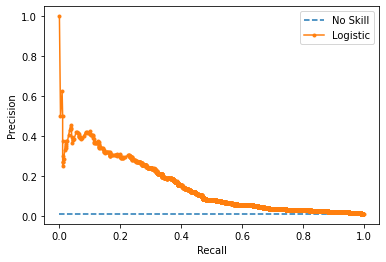

In [100]:
df_rural_test_sub_trans=logReg_pipeline.named_steps['variable_transformer'].transform(df_rural_test_sub)
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(X_bi_sample, y_bi_sample)
yhat = model.predict_proba(df_rural_test_sub_trans)
naive_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test_bi_label, naive_probs)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)
# fit a model
yhat=logReg_pipeline.named_steps['model'].predict_proba(df_rural_test_sub_trans)
model_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test_bi_label, model_probs)
auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(y_test_bi_label, model_probs)

### 3) F2 Score

In [103]:
y_pred=logReg_pipeline.named_steps['model'].predict(df_rural_test_sub_trans)

In [106]:
p = precision_score(y_test_bi_label, y_pred)
r = recall_score(y_test_bi_label,y_pred)
f = fbeta_score(y_test_bi_label, y_pred, beta=2)
f

0.013146362839614373

In [109]:
# perfect model
p = precision_score(y_test_bi_label, y_test_bi_label)
r = recall_score(y_test_bi_label,y_test_bi_label)
f = fbeta_score(y_test_bi_label, y_test_bi_label, beta=2)
f

1.0

In [113]:
# no skill model, stratified random class predictions
noskill_model = DummyClassifier(strategy='stratified')
noskill_model.fit(X_bi_sample, y_bi_sample)
noskill_pred = noskill_model.predict(df_rural_test_sub_trans)
p = precision_score(y_test_bi_label, noskill_pred)
r = recall_score(y_test_bi_label,noskill_pred)
f = fbeta_score(y_test_bi_label, noskill_pred, beta=2)
f

0.010500525026251314

### 4) Brier Skill Score

In [119]:
# calculate the brier skill score
def brier_skill_score(y_true, y_prob):
    # calculate reference brier score
    ref_prob= len(y_true[y_true==1])/len(y_true)
    ref_probs = [ref_prob for _ in range(len(y_true))]
    bs_ref = brier_score_loss(y_true, ref_probs)
    # calculate model brier score
    bs_model = brier_score_loss(y_true, y_prob)
    # calculate skill score
    return 1.0 - (bs_model / bs_ref)

In [123]:
# calculate reference
testy=y_test_bi_label
y_true=testy

ref_prob= len(y_true[y_true==1])/len(y_true)
ref_probs = [ref_prob for _ in range(len(y_true))]
brier_ref = brier_score_loss(testy, ref_probs)
print('Reference: Brier Score=%.4f' % (brier_ref))
# no skill prediction 0
probabilities = [0.0 for _ in range(len(testy))]
bss = brier_skill_score(testy, probabilities)
print('P(class1=0): BSS=%.4f' % (bss))
# no skill prediction 1
probabilities = [1.0 for _ in range(len(testy))]
bss = brier_skill_score(testy, probabilities)
print('P(class1=1): BSS=%.4f' % (bss))
# perfect probabilities
bss = brier_skill_score(testy, testy)
print('Perfect: BSS=%.4f' % (bss))
# model probabilities
probabilities = model_probs
bss = brier_skill_score(testy, probabilities)
print('Baseline: BSS=%.4f' % (bss))

Reference: Brier Score=0.0112
P(class1=0): BSS=-0.0115
P(class1=1): BSS=-87.1664
Perfect: BSS=1.0000
Baseline: BSS=0.0811


<mark>Make the above three scores part of a reporting schema, which also allows for grid-search, assinging weights, and calibration</mark>

In [16]:
weighting = compute_class_weight('balanced', [0,1], numpy.asarray(y_test_bi_label))

In [17]:
weighting

array([ 0.50573616, 44.08318584])

In [18]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
sampling=None
logReg_pipeline=func_classfication_pipeline(model, sampling)
#logReg_pipeline.fit(X_bi_sample, y_bi_sample)

In [23]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [25]:
# define grid
balance = [{0:44.08318584,1:0.50573616},{0:100,1:1}, {0:10,1:1}, {0:1,1:1}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=logReg_pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_bi_sample, y_bi_sample)
# report the best configuration
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

ValueError: Invalid parameter class_weight for estimator Pipeline(steps=[('variable_transformer',
                 FunctionTransformer(func=<function func_transform_var at 0x00000285F4AE1C80>)),
                ('sampling', None),
                ('model', LogisticRegression(max_iter=1000))],
         verbose=True). Check the list of available parameters with `estimator.get_params().keys()`.

### * Additional Resources

In [ ]:
# make custom measuring matrix
>>> from sklearn.model_selection import cross_validate
>>> from sklearn.metrics import confusion_matrix
>>> # A sample toy binary classification dataset
>>> X, y = datasets.make_classification(n_classes=2, random_state=0)
>>> svm = LinearSVC(random_state=0)
>>> def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
>>> def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
>>> def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
>>> def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
>>> scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
... 'fp': make_scorer(fp), 'fn': make_scorer(fn)}
>>> cv_results = cross_validate(svm.fit(X, y), X, y, cv=5, scoring=scoring)
>>> # Getting the test set true positive scores
>>> print(cv_results['test_tp'])
[10 9 8 7 8]
>>> # Getting the test set false negative scores
>>> print(cv_

In [ ]:
#plot confusion matrix:
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

[ROC curve resource](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py)

In [ ]:
# classificaiton report

In [ ]:
# balanced accuracy score

In [ ]:
# partial dependency plot
from sklearn.datasets import load_iris
>>> iris = load_iris()
>>> mc_clf = GradientBoostingClassifier(n_estimators=10,
... max_depth=1).fit(iris.data, iris.target)
>>> features = [3, 2, (3, 2)]
>>> plot_partial_dependence(mc_clf, X, features, target=0)

In [ ]:
import logging
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [ ]:
t0=time()
# do training etc.
print("done in %0.3fs" % (time() - t0))

In [ ]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

In [ ]:
# select important features
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(f_classif, k=4) # ANOVA F-value
X_train=selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)
fit = test.fit(X, Y)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

In [ ]:
# Recursive feature elimination
# Feature Selection with RFE
from sklearn.feature_selection import RFE
# feature extraction
model = LogisticRegression(solver='liblinear')
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

In [ ]:
# Skleanr benmark:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

In [ ]:
# skleanr benchmark plot
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
# evaluate a model
def evaluate_model(X, y, model):
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the model evaluation the metric
metric = make_scorer(brier_skill_score, needs_proba=True)
# evaluate model
scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
return scores

In [ ]:
# evaluate the model and store results
scores = evaluate_model(X, y, pipeline)
results.append(scores)
# summarize and store
print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### 1) Overall Mean Squared Error

In [4]:
import pickle
import pandas as pd
import sys; sys.path.insert(0, '..')
import importlib
import src.models
with open('../models/segment/county/tree/tree_prediction_20200421-145047.pkl', 'rb') as f:
    tree_prediction = pickle.load(f)
with open('../data/processed/df_train_label.pkl', 'rb') as f:
    df_train_label = pickle.load(f)

In [5]:
from src.models import func_rmse
importlib.reload (src.models)
overall_rmse=func_rmse(df_train_label,tree_prediction)
overall_rmse

0.08748972625960605

### 2) Cross Valuation Score

In [ ]:
from sklearn.model_selection import StratifiedKFold

<mark> Stratified K Fold </mark>  

default: a stratified 3-fold

kfold = KFold(n_splits=10, random_state=7, shuffle=True) # change to stratified K fold  
model = KNeighborsRegressor()  
scoring = 'neg_mean_squared_error'  
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)  

cross_val_score(scoring='accuracy') is really only suitable when there are an equal number of observations in each class (which is rarely the case) and that all predictions and prediction errors are equally important, which is often not the case. 

In [6]:
import pickle
import pandas as pd
with open('../models/segment/county/tree/tree_reg_20200421-145047.pkl', 'rb') as f:
    tree_reg = pickle.load(f)
with open('../data/processed/df_train_label.pkl', 'rb') as f:
    df_train_label = pickle.load(f)
with open('../data/processed/df_train_prepared.pkl', 'rb') as f:
    df_train_prepared = pickle.load(f)

In [22]:
with open('../models/segment/county/lin/lin_reg_20200416-104353.pkl', 'rb') as f:
    lin_reg = pickle.load(f)

In [77]:
importlib.reload (src.models)
from src.models import func_cross_val
cross_val_score=func_cross_val(lin_reg, df_train_prepared[:1000], df_train_label[:1000], cv=2)
cross_val_score

array([-0.0448971, -0.7151592])

### 3) Mean Squared Error by number of crashes

In [44]:
importlib.reload (src.models)
from src.models import func_rmse_crashes
crashes_rmse=func_rmse_crashes(df_train_label,tree_prediction)
crashes_rmse

[0.09180370620198626,
 0.9929393977498389,
 1.9759940161975587,
 2.9920593835749165,
 5.0065746247992955]

### 4) Mean Squared Error by functional class

In [46]:
with open('../data/processed/fnames.pkl', 'rb') as f:
    fnames=pickle.load(f)
from src.models import func_keep_var
importlib.reload (src.models)
keep_list=['functional_classification_Interstate',
           'functional_classification_Major Arterial',
           'functional_classification_Minor Arterial',
           'functional_classification_Major Collector',
           'functional_classification_Minor Collector',
           'functional_classification_Local Road or Street',]
df_Func=func_keep_var(df_train_prepared,keep_list,fnames)
df_Func

<978980x6 sparse matrix of type '<class 'numpy.float64'>'
	with 978980 stored elements in Compressed Sparse Row format>

In [47]:
importlib.reload (src.models)
from src.models import func_functional_compare
func_error=func_functional_compare(df_Func,df_train_label,tree_prediction)
func_error

[0.616422758883489,
 0.2714665948940218,
 0.1774908515077624,
 0.1439345766658114,
 0.09085741793519739,
 0.10279887623532967]

### 5) Histogram

In [51]:
with open('../models/segment/county/tree/tree_prediction_20200421-145047.pkl', 'rb') as f:
    tree_prediction = pickle.load(f)

In [52]:
importlib.reload (src.models)
from src.models import func_hist
histo=func_hist(df_train_label,tree_prediction)
histo

0.0    0.035299
1.0   -3.439012
2.0    0.268589
3.0    0.169355
4.0    0.328947
Name: diff, dtype: float64

### 6) Mapping

### * Observed crash mapping

In [7]:
import pickle
import pandas as pd
with open('../data/processed/df_geom.pkl', 'rb') as f:
    df_geom = pickle.load(f)

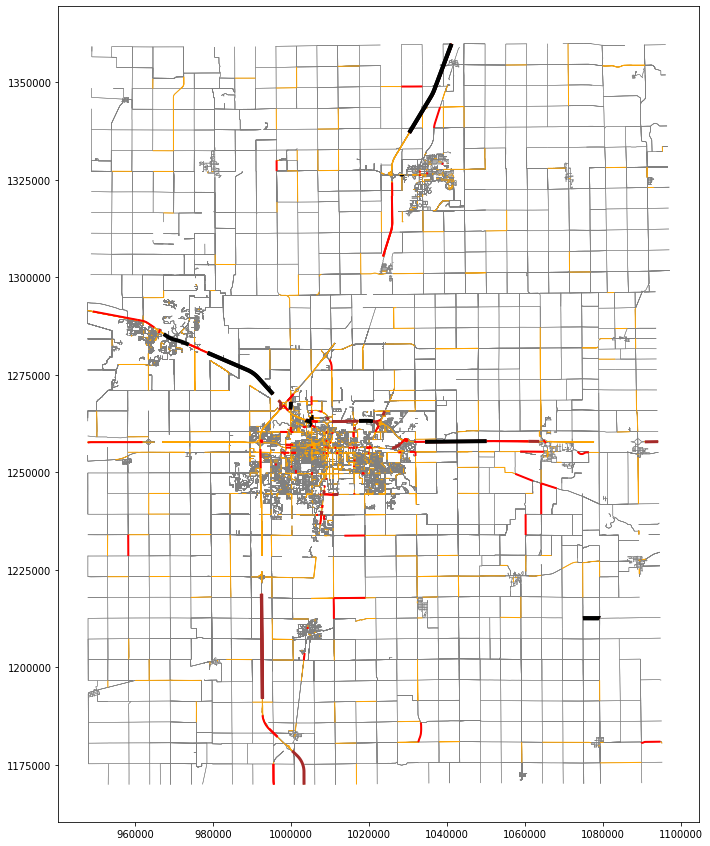

In [349]:
importlib.reload (src.models)
from src.models import observed_crashes_map
observed_crashes_map(df_geom,2017)

### * Training set modeled crashes mapping

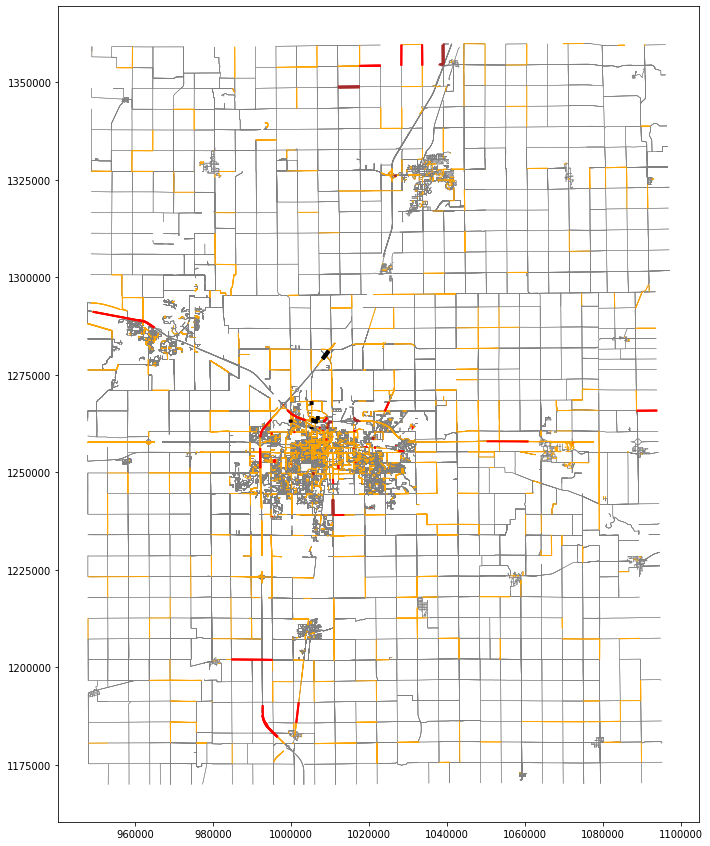

In [53]:
importlib.reload (src.models)
from src.models import prediction_maps
training_map_name='tree_prediction_20200421-145047'
prediction_maps (df_geom, tree_prediction, 2017, 'segment','county','tree',training_map_name)

### * Test set observed crashes mapping

In [12]:
with open('../models/segment/county/tree/tree_reg_20200421-145047.pkl', 'rb') as f:
    tree_reg = pickle.load(f)
with open('../data/processed/df_test_prepared.pkl', 'rb') as f:
    df_test_prepared = pickle.load(f)

In [13]:
from sklearn.tree import DecisionTreeRegressor
test_tree_prediction = tree_reg.predict(df_test_prepared)

In [15]:
with open('../models/segment/county/tree/test_tree_prediction_20200421-145047.pkl', 'wb') as f:
    pickle.dump(test_tree_prediction, f)

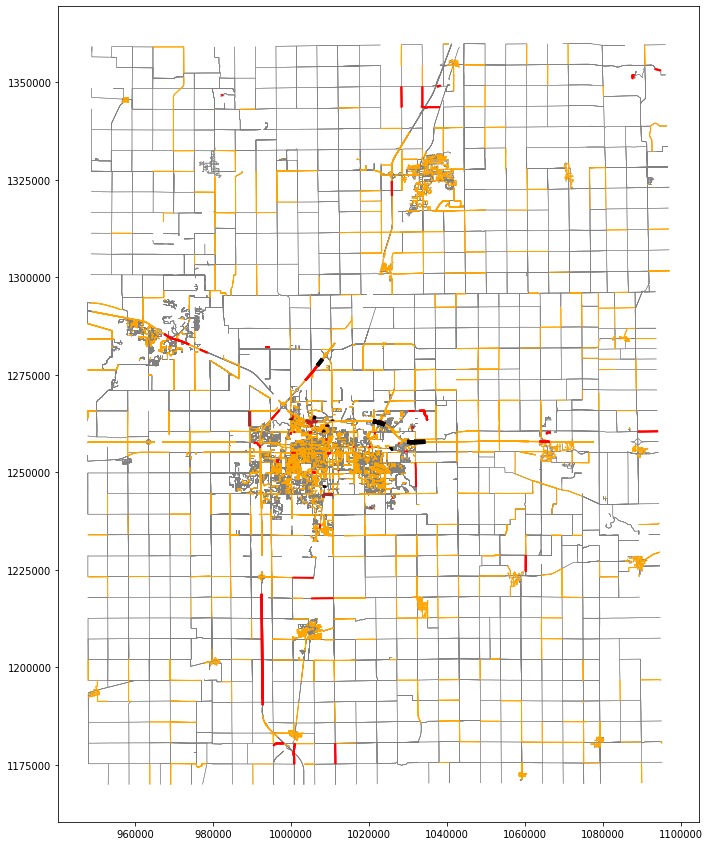

In [54]:
importlib.reload (src.models)
from src.models import test_prediction_maps
testing_map_name='test_tree_prediction_20200421-145047'
test_prediction_maps (df_geom, test_tree_prediction,'segment','county','tree', testing_map_name)

### 7) Summary report
Summarize the model results defined in the above sections and write to a log file.  
The following section documents Round 1 model run results.

To do:  
* add model parameter dictionary
* xgboost applicability
* matrices setting reading: training, testing score record

In [8]:
import pandas as pd
import datetime

In [10]:
import pickle
import sys; sys.path.insert(0, '..')
import importlib
import src.models
with open('../data/processed/df_train_prepared.pkl', 'rb') as f:
    df_train_prepared = pickle.load(f)
with open('../data/processed/df_train_label.pkl', 'rb') as f:
    df_train_label = pickle.load(f)
with open('../data/processed/fnames.pkl', 'rb') as f:
    fnames=pickle.load(f)

In [35]:
# import model results
with open('../models/segment/county/lin/lin_prediction_20200416-104353.pkl', 'rb') as f:
    lin_prediction = pickle.load(f)
with open('../models/segment/county/lin/lin_reg_20200416-104353.pkl', 'rb') as f:
    lin_reg = pickle.load(f)

In [ ]:
# import model results
with open('../models/segment/county/tree/tree_prediction_20200421-145047.pkl', 'rb') as f:
    tree_prediction = pickle.load(f)
with open('../models/segment/county/tree/tree_reg_20200421-145047.pkl', 'rb') as f:
    tree_reg = pickle.load(f)

In [54]:
# import model results
with open('../models/segment/county/xgboost/xgboost_prediction_20200416_143345.pkl', 'rb') as f:
    xgboost_prediction = pickle.load(f)
with open('../models/segment/county/xgboost/xgboost_20200416-115616.model', 'rb') as f:
    xgboost_reg = pickle.load(f)

UnpicklingError: invalid load key, '\x00'.

In [42]:
importlib.reload (src.models)
from src.models import summary_report
model_results= summary_report (tree_reg, df_train_label, tree_prediction, df_train_prepared, 2, fnames)
#model_results= summary_report (lin_reg, df_train_label, lin_prediction, df_train_prepared, 2, fnames)

In [43]:
overall_rmse = model_results[0]
cross_val_score = model_results[1]
crashes_rmse = model_results[2]
func_error = model_results[3]
histo = model_results[4]

In [44]:
training_map_name='tree_prediction_20200421-145047'
#training_map_name='lin_prediction_20200416-104353'
#importlib.reload (src.models)
#from src.models import prediction_maps
#with open('../data/processed/df_geom.pkl', 'rb') as f:
#    df_geom = pickle.load(f)
#prediction_maps (df_geom, lin_prediction, 2014, 'segment','county','lin',training_map_name)
#prediction_maps (df_geom, lin_prediction, 2015, 'segment','county','lin',training_map_name)
#prediction_maps (df_geom, lin_prediction, 2016, 'segment','county','lin',training_map_name)
#prediction_maps (df_geom, lin_prediction, 2017, 'segment','county','lin',training_map_name)

In [45]:
segment_intersection='segment'
model_geography='county'
model_type='regression'

model='lin'
model_name='lin_reg_20200416-104353'
model_parameters='null'
n_variables=len(fnames)
variables=fnames

#model='tree'
#model_name='tree_reg_20200421-145047'
#model_parameters={'max_depth': 'None'}
#n_variables=len(fnames)
#variables=fnames

In [51]:
import getpass 
username = getpass. getuser() 
log=pd.read_csv('../models/model_log.csv')  
field_names=log.columns.tolist()
model_results= {'id': log.tail(1)['id'][0]+1,
            'staff': getpass. getuser() ,
            'time_stamp': datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
            'segment_intersection': segment_intersection,
            'model_geography': model_geography,
            'model_type': model_type,
            'model': model,
            'model_name': model_name,
            'overall_rmse' : overall_rmse,
            'cross_val_score': cross_val_score,
            'crashes_rmse_0': crashes_rmse[0],
            'crashes_rmse_1': crashes_rmse[1],
            'crashes_rmse_2': crashes_rmse[2],
            'crashes_rmse_3': crashes_rmse[3],
            'crashes_rmse_4+': crashes_rmse[4],
            'func_error_interstate': func_error[0],
            'func_error_maj_art': func_error[1],
            'func_error_min_art': func_error[2],
            'func_error_maj_col': func_error[3],
            'func_error_min_col': func_error[4],
            'func_error_local': func_error[5],
            'histo_0': histo[0],
            'histo_1': histo[1],
            'histo_2': histo[2],
            'histo_3': histo[3],
            'histo_4+': histo[4],
            'map_2014': '2014_'+training_map_name,
            'map_2015': '2015_'+training_map_name,
            'map_2016': '2016_'+training_map_name,
            'map_2017': '2017_'+training_map_name,
            'model_parameters': model_parameters,
            'n_variables': n_variables,
            'variables': variables}

In [52]:
importlib.reload (src.models)
from src.models import model_log
model_log('../models/model_log.csv', model_results, field_names)

### 2) Grouped classification error

Reading list:
* [Tour of Evaluation Metrics for Imbalanced Classification(]https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)
* The 5 Classification Evaluation metrics
* 24 Evaluation Metrics for Binary Classification (And When to Use Them) 

<a id='decision-tree'></a>

## 5.5. Decision Tree

<mark> Model test range: geography + variables + pre-processing + sampling + models + hyperparameters   </mark>

In [ ]:
#use Joblib instead of pickle for model serealization 
from joblib import dump
from joblib import load
# save the model to disk
filename = 'finalized_model.sav'
dump(model, filename)
# some time later...
# load the model from disk
loaded_model = load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)

<mark>feature importance</mark>

In [1]:
print(model.feature_importances_)

NameError: name 'model' is not defined

<mark>check sparcity ratio</mark>

In [ ]:
def sparsity_ratio(X):
    return 1.0 - np.count_nonzero(X) / float(X.shape[0] * X.shape[1])
print("input sparsity ratio:", sparsity_ratio(X))

<mark>parallel</mark>

In [ ]:

from joblib import parallel_backend
with parallel_backend('threading', n_jobs=2):
# Your scikit-learn code here

<mark>weighted tree</mark>

In [ ]:
weights = {0:1.0, 1:100.0} 
class_weight=weights
#or   
from sklearn.utils.class_weight import compute_class_weight
weighting = compute_class_weight('balanced', [0,1], y) 
class_weight='balanced' 
#Grid-search  
# define grid  
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}] 
param_grid = dict(class_weight=balance)  
# define evaluation procedure  
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)  
# define grid search 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search  
grid_result = grid.fit(X, y) 
# report the best configuration  
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))  

<mark> Model run with selected improtant features</mark>

In [ ]:
from sklearn.feature_selection import SelectFromModel
# fit model on all training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
# select features using threshold
selection = SelectFromModel(model, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
predictions = selection_model.predict(select_X_test)
accuracy = accuracy_score(y_test, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1],
accuracy*100.0))

In [ ]:
import pickle
import pandas as pd
with open('../data/processed/df_train_prepared.pkl', 'rb') as f:
    df_train_prepared = pickle.load(f)
with open('../data/processed/df_train_label.pkl', 'rb') as f:
    df_train_label = pickle.load(f)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_train_prepared, df_train_label)

In [ ]:
from sklearn.metrics import mean_squared_error
tree_prediction = tree_reg.predict(df_train_prepared)
tree_mse = mean_squared_error(df_train_label, tree_prediction )
tree_rmse = np.sqrt(tree_mse)
tree_rmse ## 0.087, better than linear regressor's 0.1215

In [ ]:
import pickle
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
with open('../models/segment/county/tree/tree_reg_'+timestr+'.pkl', 'wb') as f:
    pickle.dump(tree_reg, f)
with open('../models/segment/county/tree/tree_prediction'+timestr+'.pkl', 'wb') as f:
    pickle.dump(tree_prediction, f)

In [ ]:
with open('../models/segment/county/tree/tree_reg_20200421-145047.pkl', 'rb') as f:
    tree_reg = pickle.load(f)
with open('../models/segment/county/tree/tree_reg_20200421-145047.pkl', 'rb') as f:
    tree_prediction = pickle.load(f)

### 1) Optimized tree depth

The depth of a well-balanced binary tree containing m leaves is equal to log2(m), rounded up. 

In [ ]:
df_train_label.shape[0] # Approximately 1 million training instances

In [ ]:
import math
math.log2(df_train_label.shape[0])

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg_depth20 = DecisionTreeRegressor(max_depth=20)
tree_reg_depth20.fit(df_train_prepared, df_train_label)

tree_prediction_depth20 = tree_reg_depth20.predict(df_train_prepared)

In [ ]:
tree_mse = mean_squared_error(df_train_label, tree_prediction_depth20)
tree_rmse = np.sqrt(tree_mse)
tree_rmse ## 0.102

### 2) Visualizing the tree

Tree structure indicates that heavy vehicle counts (HCV), AADT of crossing streets, segment length, AADT, lane configuration, and maximum lanes-crossed are the important features. Restricting the maximum-depth of the tree does not impact the initial branches. 

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,4), dpi=300)
            
tree.plot_tree(tree_reg, 
               max_depth=2,
               feature_names = fnames,
               filled=True,
               proportion=True,
               fontsize=8
)
timestr = time.strftime("%Y%m%d-%H%M%S")
fig.savefig('../reports/figures/model_results/segment/county/tree/DecisionTree_Depth3_'+timestr+'.png')

### 2) Model Performance

Tree with 20 maximum depth will generally perform worse than a tree with no depth limitations

In [ ]:
# 10 segments with more than 1 crashes
t_label=df_train_label[df_train_label>=1].head(10)
t_index=t_label.index.tolist()
t_label

In [ ]:
t=df_train_prepared[t_index]
t

In [ ]:
t_tree_prediction=tree_reg.predict(t)
t_tree_prediction

In [ ]:
t_tree_depth20_prediction=tree_reg_depth20.predict(t)
t_tree_depth20_prediction

In [ ]:
t_label

In [ ]:
plt.hist(tree_prediction) 
plt.title("histogram") 
plt.show()

In [ ]:
plt.hist(tree_prediction_depth20) 
plt.title("histogram") 
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_scores
cores = cross_val_score(tree_reg, df_train_prepared, df_train_label,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
display_scores(tree_rmse_scores)

* Scores: [0.13661763 0.17026498 0.13604928 0.14240234 0.12886054 0.13806345 0.16688535 0.12048619 0.16215687 0.13385693]  
* Mean: 0.1435643563374312  
* Standard deviation: 0.01606815155715894  

In [ ]:
scores = cross_val_score(tree_reg_depth20, df_train_prepared, df_train_label,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

In [ ]:
observed_crashes_map (2015)

In [ ]:
prediction_maps (tree_prediction, 2015)

In [ ]:
prediction_maps (tree_prediction_depth20, 2015) # Much worse than unconstrained tree

In [ ]:
test_tree_prediction = tree_reg.predict(df_test_prepared)
test_prediction_maps (test_tree_prediction)

<a id='random-forest'></a>

## 5.6. Random Forest

This takes too long to run  
<mark>try setting number of tree and max number of features </mark>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(df_train_prepared, df_train_label)
forest_rmse

In [ ]:
t_prediction=forest_reg.predict(t)
t_prediction

In [ ]:
df_train_prediction = forest_reg.predict(df_train_prepared)
plt.hist(df_train_prediction) 
plt.title("histogram") 
plt.show()

In [ ]:
scores = cross_val_score(forest_reg, df_train_prepared, df_train_label,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [ ]:
display_scores(forest_rmse_scores)

<mark> Try balanced random forest </mark>

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
# define model
model = BalancedRandomForestClassifier(n_estimators=10)

In [ ]:
<mark> Try Easy Ensamble Classifier </mark>

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier

In [ ]:
# define model
model = EasyEnsembleClassifier(n_estimators=10)

<a id='svm'></a>

## 5.7. Support Vector Machines

<a id='xgboost'></a>

## 5.8. Extreme Gradient Boosting (XGBoost)

<mark> Test how XGBoost performs with different ways of handling missing values</mark>

In [ ]:
# Reference: https://github.com/dwilson1988/azure-utah-accidents-prediction/blob/master/notebooks/4_train_model.ipynb

### 1) Regression Problem

In [ ]:
fnames

In [ ]:
import pickle
with open('../data/processed/fnames.pkl', 'rb') as f:
    fnames = pickle.load(f)

In [ ]:
df_train_prepared[:1000]

In [ ]:
import xgboost

dtrain = xgboost.DMatrix(df_train_prepared,label=df_train_label,feature_names=fnames)
dtest = xgboost.DMatrix(df_test_prepared,label=df_test_label,feature_names=fnames)

params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'reg:squarederror',
    'eta':0.5
}

In [ ]:
dtrain

In [ ]:
dtest

In [ ]:
booster = xgboost.train(params,dtrain,
    evals = [(dtest, 'eval')],
    num_boost_round=3000,
    early_stopping_rounds=25
) # Best iteration: [87] eval-auc:0.832059

#### * Feature Importance

In [ ]:
plt.figure(figsize=(15,45))
xgboost_feature_importance=xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

In [ ]:
xgboost_feature_importance.figure.savefig('xgboost_feature_importance.png')

<img src="xgboost_feature_importance.png">

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
booster.save_model('xgboost_'+timestr+'.model')

In [ ]:
xgboost_prediction = booster.predict(dtrain)
test_xgboost_prediction = booster.predict(dtest)

In [ ]:
import pickle
timestr = time.strftime("%Y%m%d-%H%M%S")
with open('../models/segment/county/xgboost/xgboost_prediction_'+timestr+'.pkl', 'wb') as f:
    pickle.dump(xgboost_prediction, f)
with open('../models/segment/county/xgboost/test_xgboost_prediction_'+timestr+'.pkl', 'wb') as f:
    pickle.dump(test_xgboost_prediction, f)

In [ ]:
with open('../models/segment/county/xgboost/xgboost_prediction_20200416_143345.pkl', 'rb') as f:
    xgboost_prediction = pickle.load(f)
with open('../models/segment/county/xgboost/test_xgboost_prediction_20200416_143345.pkl', 'rb') as f:
    test_xgboost_prediction = pickle.load(f)

#### * Model Performance

In [ ]:
plt.hist(xgboost_prediction) 
plt.title("histogram") 
plt.show()

In [ ]:
xgboost_mse = mean_squared_error(df_train_label, xgboost_prediction )
xgboost_rmse = np.sqrt(xgboost_mse)
xgboost_rmse ## 0.109

In [ ]:
test_prediction_maps (test_xgboost_prediction)

### 2) Classification Problem

In [ ]:
# plot tree
from xgboost import plot_tree
# fit model on training data
model = XGBClassifier()
model.fit(X, y)
# plot single tree
plot_tree(model) # num_trees=0 for the nth boosted tree, rankdir='LR' for a horizontal tree plot
pyplot.show()

In [ ]:
# plot feature importance 
from xgboost import plot_importance
# fit model on training data
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()

<mark>KeyError: 'weight' fix</mark>

In [ ]:
#define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None

 # fit model on all training data
model = MyXGBClassifier()

#### * Model Performance

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# define model
model = XGBClassifier()
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000] # rule of thumb: sclae_pos_weight=majority class /minority class
param_grid = dict(scale_pos_weight=weights) 
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv,
scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
y_pred_test = booster.predict(dtest)

fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(dtrain)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [ ]:
test_xgboost_prediction

In [ ]:
df_test_label.to_numpy(dtype='float32')

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve

test_xgboost_prediction = booster.predict(dtest)
fpr, tpr, thresholds = roc_curve(df_test_label.to_numpy(dtype='float32'),test_xgboost_prediction)

xgboost_prediction = booster.predict(dtrain)
fpr_train, tpr_train, thresholds_train = roc_curve(df_train_label,xgboost_prediction)

In [ ]:
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [ ]:
xgb_clf = xgboost.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)    

In [ ]:
#k-fold Cross Validation using XGBoost
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [ ]:
cv_results.head()

In [ ]:
#Visualize Boosting Trees and Feature Importance
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train)

In [ ]:
# early stopping to avoid overfitting
# fit model on training data
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
# make predictions

In [ ]:
# Evaluate XGBoost Models With Learning Curves 
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# load data (dataset)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model on training data
model = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set,
verbose=True)
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

<mark>Multi-threading</mark>

In [ ]:
from time import time
from matplotlib import pyplot
# load data
# evaluate the effect of the number of threads: 6 core CPU
results = []
num_threads = [1, 2, 3, 4]
for n in num_threads:
    start = time()
    model = XGBClassifier(nthread=n)
    model.fit(X, label_encoded_y)
    elapsed = time() - start
    print(n, elapsed)
results.append(elapsed)
# plot results
pyplot.plot(num_threads, results)
pyplot.ylabel('Speed (seconds)')
pyplot.xlabel('Number of Threads')
pyplot.title('XGBoost Training Speed vs Number of Threads')
pyplot.show()

In [ ]:
# Parallel Thread XGBoost and CV
start = time.time()
model = XGBClassifier(nthread=-1)
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='neg_log_loss', n_jobs=-1)
elapsed = time.time() - start
print("Parallel Thread XGBoost and CV: %f" % (elapsed))

<mark>Running XGBoost on AWS </mark> (xgboost with python book chapter 12)

Tuning  
  * Num_round (target around 100 tress) 
  * learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]  
  * max_depth: determines how deeply each tree is allowed to grow during any boosting round, start with 6  
  * Min_child_weightL start with 1/sqrt 
  * subsample: percentage of samples used per tree. Low value can lead to underfitting. (leave at 1)  
  * colsample_bytree: percentage of features used per tree. High value can lead to overfitting. (0.3-0.5)  
  * n_estimators: number of trees you want to build.  

Most important tuning parameters: 
  * n_estimators: number of trees you want to build.   
  * learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]  
  * max_depth: determines how deeply each tree is allowed to grow during any boosting round, start with 6  

Strategy:
  * Number of Trees and Learning Rate: Fix the number of trees at around 100   
  * Max Tree Depth: Start with a value of 6 and presumably tune from there.  
  * Min Leaf Weight: Use a modified ratio of 1 sqrt(rare events) , where rare events is the percentage of rare event observations in the dataset.  
  * Column Sampling: Grid search values in the range of 0.3 to 0.5 (more constrained).  
  * Row Sampling: Fixed at the value 1.0.  
  * Min Split Gain: Fixed at the value 0.0.   
			
XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.    
  * gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners. (leave at 0)  
  * alpha: L1 regularization on leaf weights. A large value leads to more regularization.  
  * lambda: L2 regularization on leaf weights and is smoother than L1 regularization.   

"What is interesting to note is that this world class practitioner does not fiddle with gamma or the terms for the regularization penalty (reg alpha and reg lambda)."  

source: https://www.youtube.com/watch?v=7YnVZrabTA8  

In [ ]:
# grid search
model = XGBClassifier()
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold,
verbose=1)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth.png')

In [ ]:
import xgboost as xgb

<a id='resources'></a>

## Resources

In [ ]:
# create pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lda', LinearDiscriminantAnalysis()))
model = Pipeline(estimators)
# evaluate pipeline
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

In [ ]:
# create feature union
features = []
features.append(('pca', PCA(n_components=3)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', LogisticRegression(solver='liblinear')))
model = Pipeline(estimators)
# evaluate pipeline
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

In [ ]:
def get_models():
    models, names = list(), list()
    # SMOTEENN
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('sampling', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('LR')

## Linear Regression

This is just for fun. This is not a linear problem, of course.

In [32]:
import pickle
import pandas as pd
with open('../data/processed/df_train_prepared.pkl', 'rb') as f:
    df_train_prepared = pickle.load(f)
with open('../data/processed/df_train_label.pkl', 'rb') as f:
    df_train_label = pickle.load(f)

In [33]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(df_train_prepared, df_train_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
import pickle
with open('../models/segment/county/lin/lin_reg_20200416-104353.pkl', 'wb') as f:
    pickle.dump(lin_reg, f)

Test the model with a few instances where number of crashes are >=1.

In [ ]:
t_label=df_train_label[df_train_label>=1].head(10)
t_index=t_label.index.tolist()
t_label

In [ ]:
t=df_train_prepared[t_index]
t

In [ ]:
t_lin_prediction=lin_reg.predict(t)
t_lin_prediction

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
lin_prediction=lin_reg.predict(df_train_prepared)
lin_mse = mean_squared_error(df_train_label, lin_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
test_lin_prediction=lin_reg.predict(df_test_prepared)

In [ ]:
import pickle
timestr = time.strftime("%Y%m%d-%H%M%S")
with open('../models/segment/county/lin//lin_prediction_'+timestr+'.pkl', 'wb') as f:
    pickle.dump(lin_prediction, f)

In [ ]:
import pickle
import pandas as pd
with open('../models/segment/county/lin/lin_prediction_20200416-104353.pkl', 'rb') as f:
    lin_prediction = pickle.load(f)

In [ ]:
df_train_label.value_counts()

In [ ]:
from matplotlib import pyplot as plt 
plt.hist(df_train_label) 
plt.title("histogram") 
plt.show()

In [ ]:
lin_prediction

In [ ]:
lin_prediction_geom = df_geom.merge(pd.Series(lin_prediction,name='prediction').to_frame(),  left_index=True, right_index=True, how='right') 

In [ ]:
import geopandas as gpd
lin_prediction_geom  = gpd.GeoDataFrame(lin_prediction_geom , geometry=lin_prediction_geom['geometry'])
lin_prediction_geom 

In [ ]:
lin_prediction_geom['Crashes_cat']=lin_prediction_geom['Crashes']

In [ ]:
lin_prediction_geom.loc[lin_prediction_geom['Crashes']>3,'Crashes_cat']='4+'

In [ ]:
lin_prediction_geom['Crashes_cat'].value_counts()

In [ ]:
lin_prediction_geom['Crashes_cat']=lin_prediction_geom['Crashes_cat'].astype('category')

In [ ]:
lin_prediction_geom['Crashes_cat']=lin_prediction_geom['Crashes_cat'].apply(str)

In [ ]:
lin_prediction_geom['Crashes_cat'].dtype

In [ ]:
type(lin_prediction_geom)

In [ ]:
lin_prediction_geom.to_csv('lin_prediction_geom.csv')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
lin_prediction_geom[lin_prediction_geom['Year']==2014].plot(column='Crashes',ax=ax, legend=True)

In [ ]:
fig.savefig('../reports/figures/observed_crashes/observed_crashes_2014.png')

In [ ]:
observed_crashes_map (2017)

In [ ]:
plt.hist(lin_prediction) 
plt.title("histogram") 
plt.show()

In [ ]:
fig_predict, ax = plt.subplots(1, 1, figsize=(15,15))
lin_prediction_geom[lin_prediction_geom['Year']==2014].plot(column='prediction',ax=ax, legend=True)

In [ ]:
fig_predict.savefig('../reports/figures/model_results/segment/county/lin/linear_predicted_crashes_2014.png')

In [ ]:
prediction_maps (lin_prediction, 2017)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

Cross-valuation score  
Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the following code computes -scores before calculating the square root.

In [ ]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, df_train_prepared, df_train_label,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

This linear regression model underfits the training data. This is because crash prediction is not a linear problem. 
* Scores: [0.12490167 0.13783364 0.10029124 0.12697275 0.11578172 0.12128252 0.14171662 0.1079799  0.12681254 0.10972952]  
* Mean: 0.12133021096380703  
* Standard deviation: 0.012445285881507092  

In [ ]:
test_observed_crashes_map ()

In [ ]:
test_prediction_maps (test_lin_prediction)

<a id='negative-binomial-regression'></a>

## Negative Binomial Regression

In [ ]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
pdf_train_prepared_noyear=pd.DataFrame.sparse.from_spmatrix(df_train_prepared[:,no_year]).reset_index(drop=True)
pdf_train_prepared_noyear.head(1)

In [ ]:
pdf_train_prepared_noyear.shape

In [ ]:
pdf_train_label=pd.DataFrame(df_train_label).reset_index(drop=True)
pdf_train_label.head(1)

In [ ]:
pdf_train_label.isnull().sum()

In [ ]:
sum(pdf_train_prepared_noyear.isnull().sum())

In [ ]:
pdf_train_prepared_noyear.notnull().values.all()

In [ ]:
pdf_train_label.shape

In [ ]:
pdf_train_label.mean()

In [ ]:
pdf_train_label.var()

In [ ]:
pdf_train_label.var()/pdf_train_label.mean() #Variance-mean ratin

For crash data, the variance (0.015843) is greater than the mean (0.01232), a property called over-dispersion, which makes Poisson Regression not suitable for modeling. As discussed in the literature section, the Highway Safety Manual (HSM) assumes crashes follow a negative binomial regression. 

Assume: vairance = mean + a * mean^2 (NB2)  
Reference: [Summary of NB2 regression strategy](https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4)
* Step 1: Fit the Poisson regression model on the data set. This will give us the vector of fitted rates λ.
* Step 2: Fit the aux OLS regression model on the data set. This will give us the value of α.
* Step 3: Use the α from STEP 2 to fit the NB2 regression model to the data set.
* Step 4: Use the fitted NB2 model to make predictions about expected counts on the test data set.
* Step 5: Test the goodness-of-fit of the NB2 model.

### * Step 1

<mark>Take log of the variables (AADT, segment length, etc.)?</mark>

In [ ]:
pdf_train_label_500=pdf_train_label.head(500)
pdf_train_prepared_noyear_500=pdf_train_prepared_noyear.head(500)

poisson_reg = sm.GLM(pdf_train_label_500, pdf_train_prepared_noyear_500, family=sm.families.Poisson()).fit()   
NaN, inf or invalid value detected in weights, estimation infeasible.

#### * Zero Inflated Poisson Model  
[Reference](https://www.statsmodels.org/stable/generated/statsmodels.discrete.count_model.ZeroInflatedNegativeBinomialP.html)

In [ ]:
import statsmodels.discrete.count_model as reg_models

In [ ]:
out=reg_models.ZeroInflatedPoisson(pdf_train_label_500,pdf_train_prepared_noyear_500, inflation='logit')

In [ ]:
fit=out.fit(method='bfgs', maxiter = 1000)

In [ ]:
fit.summary()

In [ ]:
fit.params

In [ ]:
fit.mu

In [ ]:
print(poisson_reg.summary())

In [ ]:
pdf_test_prepared_noyear=pd.DataFrame.sparse.from_spmatrix(df_test_prepared[:,no_year]).reset_index(drop=True)
pdf_test_label=pd.DataFrame(df_test_label).reset_index(drop=True)

In [ ]:
poisson_prediction = poisson_reg .get_prediction(pdf_test_prepared_noyear)
poisson_summary = poisson_prediction.summary_frame()
print(poisson_summary)

In [ ]:
# feature importance
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
# Trasnformer to select only the most important attributes
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [ ]:
#Define number of features to keep
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

In [ ]:
#Randomized Grid Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
#A full pipeline with both preparation and prediction
full_pipeline_with_predictor = Pipeline([
        ("preparation", preprocess_pipeline),
        ('feature_selection', TopFeatureSelector(feature_importances, k)),
        ('svm_reg', SVR(**rnd_search.best_params_))
    ])

full_pipeline_with_predictor.fit(X_train, y_train)
full_pipeline_with_predictor.predict(X_test)

In [ ]:
# Grid search for data preparation options
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(X_train, y_train)

In [ ]:
# Save model using joblib
my_model = full_pipeline_with_predictor
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

### 1) Stochastic Gradient Descent Classifier (SGD)
[[back to top](#sections)]

In [ ]:
#SGD Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [ ]:
#Performance measure: Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

In [ ]:
#Performance measure: precision-recall curve
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.plot([7813, 7813], [0., 0.9], "r:")        
#plt.plot([-50000, 7813], [0.9, 0.9], "r:")      
#plt.plot([-50000, 7813], [0.4368, 0.4368], "r:")
#plt.plot([7813], [0.9], "ro")                   
#plt.plot([7813], [0.4368], "ro")                
save_fig("precision_recall_vs_threshold_plot")  
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

<a id='sgd-pm'></a>

#### Performance Measure

In [ ]:
#Performance measure: ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores) #closer to 1 the better

In [ ]:
# confusion matrix (lit review 31, pg. 17-18)

<a id='sgd-time'></a>

#### Training Time

In [ ]:
import time
t0 = time.time()
ClassifierX.fit(X_train, y_train)
t1 = time.time()

In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

<a id='random-forest-classifier'></a>

### 2) Random Forest Classifier
[[back to top](#sections)]

In [ ]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
                                    method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)
roc_auc_score(y_train, y_scores_forest)
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3)
precision_score(y_train, y_train_pred_forest)
recall_score(y_train, y_train_pred_forest)

In [ ]:
#SGD

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(X_test)

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
#confusion matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [ ]:
#confusion rate matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [ ]:
#Random Forest
#naive Bayes


In [ ]:
#KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{'n_neighbors': [3,4,5], 'weights': ["uniform", "distance"]}]

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

<a id='support-vector-machine-classifer'></a>

### 3) Support Vector Machine Classifer (SVC)
[[back to top](#sections)]

In [ ]:
#Support Vector Machine Classifer (SVC)
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train, y_train)
svm_clf.predict(X_test)

<a id='XGBoost'></a>